<a href="https://colab.research.google.com/github/rakkhrok/bsi_method_analysis/blob/main/gtsrb_art_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Mount Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Check that the drive is mounted
!ls "/content/drive/My Drive/GoogleCollab"
drive_dir = "/content/drive/My Drive/GoogleCollab"

gtsrb_architecture_training.ipynb  gtsrb_dataset  pickles
gtsrb_art_model_training	   models	  sandbox_art.ipynb


In [3]:
#!pip install numpy==1.23.5

In [4]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/mnist_cnn_fgsm.py
import tensorflow as tf
from tensorflow import keras

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np


import warnings
warnings.filterwarnings('ignore')

from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from __future__ import absolute_import, division, print_function, unicode_literals

from art import config
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [18]:
import os
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data Set specifics

In [19]:
# Set the paths to our data
# The smallest image in this set is 30X30, so this will be the default size for all images
data_dir = drive_dir + '/gtsrb_dataset'
train_path = drive_dir + '/gtsrb_dataset/Train'
test_path = drive_dir + '/gtsrb_dataset/Test'
IMG_HEIGHT = 30
IMG_WIDTH = 30

In [9]:
# Number of Classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [10]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }



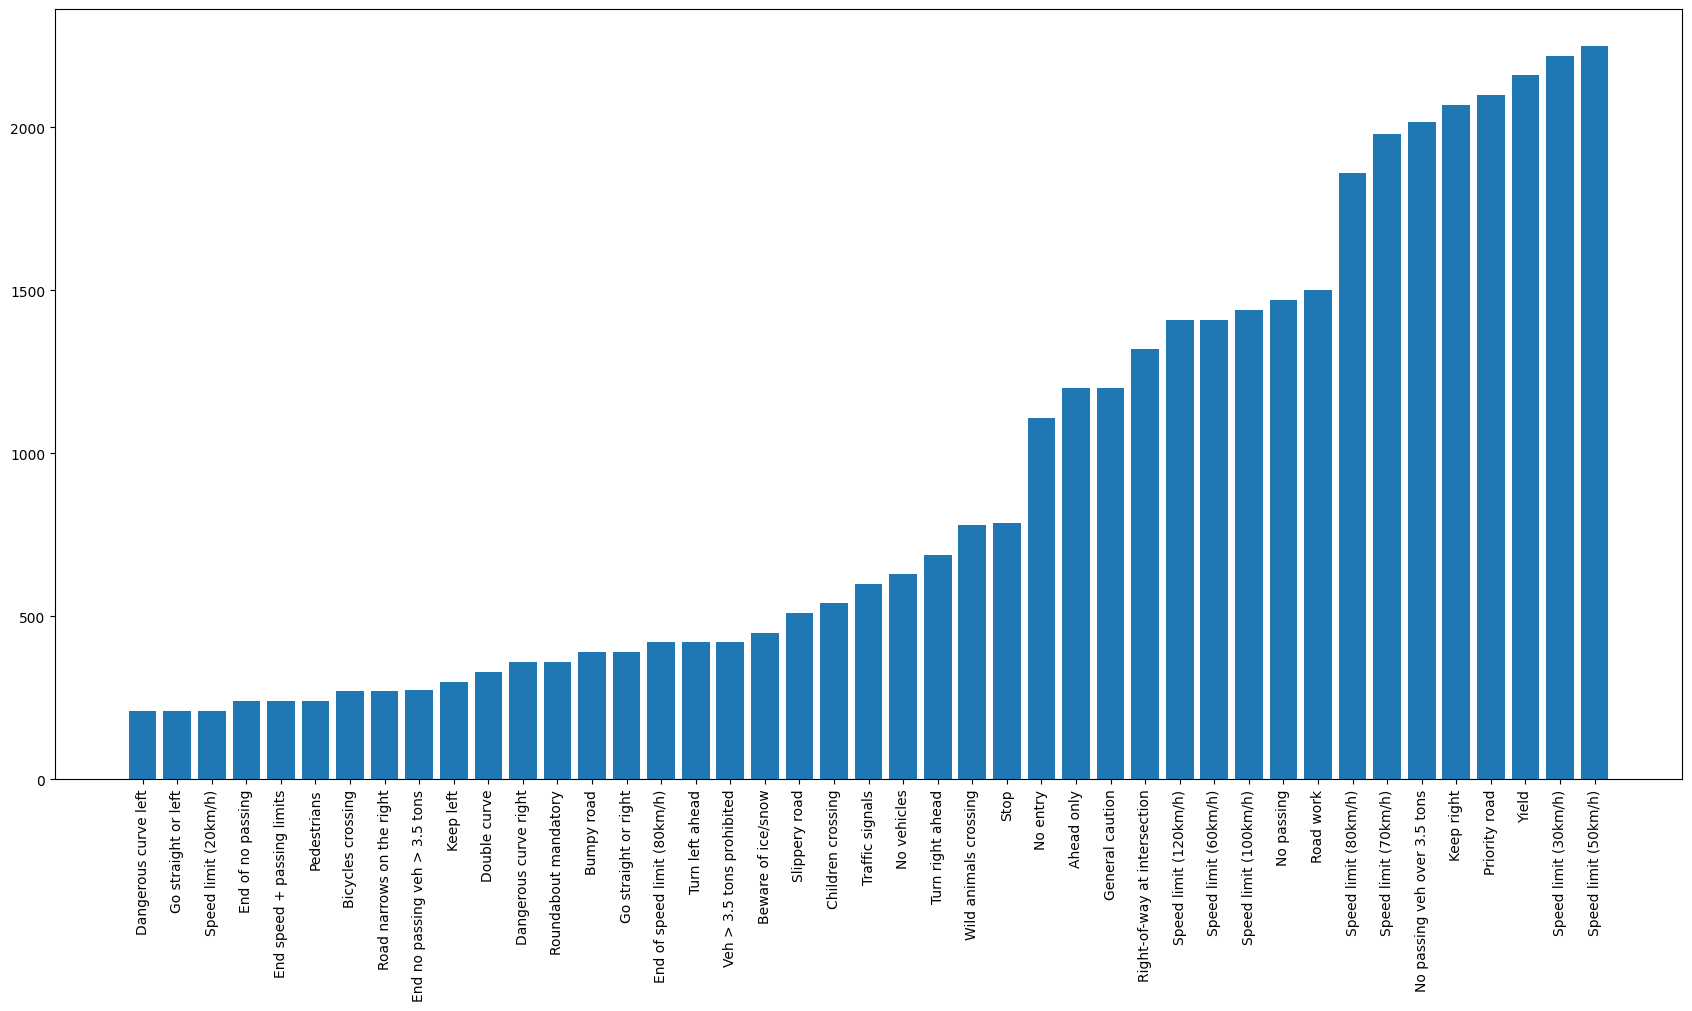

In [13]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [14]:
# Crack the jar
with open(drive_dir + '/pickles/image_data.npy', 'rb') as f1:
  image_data = np.load(f1)
with open(drive_dir + '/pickles/image_labels.npy', 'rb') as f2:
  image_labels = np.load(f2)

In [15]:
# Shuffling the training data

shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [48]:
# Splitting the data into train and validation set

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27477, 30, 30, 3)
X_valid.shape (11777, 30, 30, 3)
y_train.shape (27477,)
y_valid.shape (11777,)


In [24]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27477, 43)
(11777, 43)


In [27]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Third Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

# Flattening the layer and adding Dense Layer
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

In [36]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Step 3: Create the ART classifier
classifier = KerasClassifier(model=model)

In [39]:
classifier_model = load_model(drive_dir +  "/models/base_model_gtsrb.h5")
classifier = KerasClassifier(model=classifier_model, use_logits=False)

In [43]:
# Crack the jar
with open(drive_dir + '/pickles/test_image_data.npy', 'rb') as f4:
  X_test = np.load(f4)


In [49]:
# Create maling adversarial examples 
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=X_val)

In [52]:
#  Evaluate the GTSRB classifier on adversarial test examples
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_val, axis=1)) / len(y_val)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

AxisError: ignored